In [8]:
from perceiver.model.core import FourierPositionEncoding
import torch
import torch.nn as nn
from torchvision import datasets
from einops import rearrange, repeat
import matplotlib.pyplot as plt

In [3]:
MNIST_data_dir = '/home/nsk/repos/ml-trial-room/mnist/MNIST_data'
mnist_trainset = datasets.MNIST(MNIST_data_dir, download=False)

In [37]:
img_1 = mnist_trainset.data[0]
img_2 = mnist_trainset.data[1]
img_shape = img_1.shape
print(img_1.shape)

img_1 = rearrange(img_1, 'h w -> () (h w) ()')
img_2 = rearrange(img_2, 'h w -> () (h w) ()')

torch.Size([28, 28])


In [60]:
pos_enc = FourierPositionEncoding(input_shape=img_shape, num_frequency_bands=2)
enc = pos_enc(1)
enc.shape

torch.Size([1, 784, 10])

In [61]:
inp = torch.cat([torch.cat([img_1, enc], dim=-1), torch.cat([img_2, enc], dim=-1)], dim=1)
inp.shape

torch.Size([1, 1568, 11])

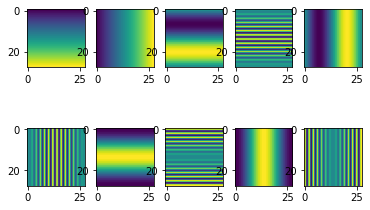

In [59]:
# plot as a heatmap, all 10 channels in a grid
fig, axs = plt.subplots(2, 5)
for i in range(10):
    axs[i // 5, i % 5].imshow(split[0, :, :, i+1].numpy())
plt.show()
# plt.imshow(split[0, :, :, 3].numpy())
# plt.show()

In [4]:
imgs = mnist_trainset.data[:2]
imgs = rearrange(imgs, 'i h w -> () (i h w) ()')

In [94]:
enc_cat = torch.cat([enc, enc], dim=1)
imgs_w_enc = torch.cat([imgs, enc_cat], dim=-1)

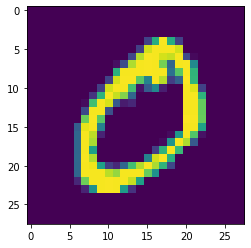

In [98]:
split = rearrange(imgs_w_enc, "b (i h w) c -> i (b c) h w ", w=28, h=28)
plt.imshow(split[1, 0, :, :].numpy())
plt.show()

In [6]:
class ModalityEncoding(nn.Module):
    '''Provider of the modality encoding for the student model.
    '''
    def __init__(self, num_dim: int, init_scale: float = 0.02):
        super().__init__()
        self._enc = nn.Parameter(torch.empty(num_dim))
        self._init_params(init_scale)

    def _init_params(self, init_scale: float):
        with torch.no_grad():
            self._enc.normal_(0, init_scale)

    def forward(self, x=None):
        return self._enc
mods = torch.stack([ModalityEncoding(5)() for _ in range(2)])

In [13]:
repeat(mods, 'i e -> b (i h w) e', b=1, h=2, w=2)

tensor([[[-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0099,  0.0018, -0.0193,  0.0228, -0.0162],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031],
         [-0.0175, -0.0187,  0.0026,  0.0192, -0.0031]]],
       grad_fn=<UnsafeViewBackward0>)

In [4]:
import numpy as np
np.linalg.norm([[1, 2, 3], [4, 5, 4]], axis=0)

array([4.12310563, 5.38516481, 5.        ])

In [8]:
x = np.array([1,2,3,4,5,4])
x[x>4] = 4
x

array([1, 2, 3, 4, 4, 4])